# 0- Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import numpy as np

import time

# 1- Import data

In [2]:
torch.backends.cudnn.deterministic = True
LABEL = data.LabelField(dtype = torch.float)
TEXT = data.Field(tokenize = 'spacy', include_lengths = True, lower = False)
fields = [(None, None),(None, None), (None, None), (None, None),(None, None),(None, None), ('label', LABEL),(None, None),(None, None), (None, None),(None, None),('text',TEXT)]
train_data = data.TabularDataset(path = 'data/data_filtered2_balanced_all.csv', format = 'csv', fields = fields, skip_header = True)
print(f'Number of data examples: {len(train_data)}')

train_data, test_data = train_data.split(0.8)
train_data, valid_data = train_data.split(0.8)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of data examples: 98474
Number of training examples: 63023
Number of validation examples: 15756
Number of testing examples: 19695


# 2- Build vocabulary - GloVe

In [3]:
MAX_VOCAB_SIZE = 95_000 #most common words
MIN_FREQ = 2 #minimum frequency not to be unknown
LABEL.build_vocab(train_data)
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.50d", 
                 unk_init = torch.Tensor.normal_)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

print(f"Most common words: {TEXT.vocab.freqs.most_common(20)}") #most common words
print(f"Vocabulary:{TEXT.vocab.itos[:10]}") #to see vocabulary
print(f"Labels: {LABEL.vocab.stoi}") #to see labels

.vector_cache\glove.6B.zip: 862MB [06:35, 2.18MB/s]                                                                    
100%|██████████████████████████████████████████████████████████████████████▋| 398334/400000 [00:20<00:00, 20601.58it/s]

Unique tokens in TEXT vocabulary: 91291
Unique tokens in LABEL vocabulary: 2
Most common words: [('.', 294371), (',', 233816), ('the', 216562), ('I', 198257), ('and', 152974), ('a', 144218), ('to', 130033), (' ', 123383), ('it', 108363), ('of', 105556), ('is', 91896), ('in', 67853), ('this', 66411), ('for', 64898), ('that', 58355), ('was', 44665), ('my', 44309), ('you', 43759), ('with', 42727), ('not', 42335)]
Vocabulary:['<unk>', '<pad>', '.', ',', 'the', 'I', 'and', 'a', 'to', ' ']
Labels: defaultdict(<function _default_unk_index at 0x00000236128357B8>, {'1': 0, '0': 1})


100%|██████████████████████████████████████████████████████████████████████▋| 398334/400000 [00:40<00:00, 20601.58it/s]

# 3- Build iterators

In [4]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

''''train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)'''

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.text), #sort by s attribute (quote)
    sort_within_batch=True,
    batch_size=BATCH_SIZE,
    device=device)

# 4- Build the model

In [5]:
#1- Define the model

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))
    
#2- Create an instance of the RNN class

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 100
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.9
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

#3-  Trainable parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters') #much more than in version 1

#4- Copy pre trained word embeddings into "embedding" layer of our model

pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape) #check correct size [vocab size, embedding dim]

#5- Replace the initial weights of the "embedding" layer with the "pre-trained embeddings"

model.embedding.weight.data.copy_(pretrained_embeddings)
    
#6 - <unk> and <pad>

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data) #check that first two rows set to zero

The model has 4,927,951 trainable parameters
torch.Size([91291, 50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [ 0.4036, -0.5536,  0.6136,  ..., -1.1557, -0.6797,  1.3941],
        [-0.5343, -0.1317,  1.7530,  ..., -0.2506,  0.2728,  1.4663],
        [-0.4757, -0.7174, -0.4006,  ...,  0.2333,  0.5503,  0.4347]])


# 5 - Train the model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


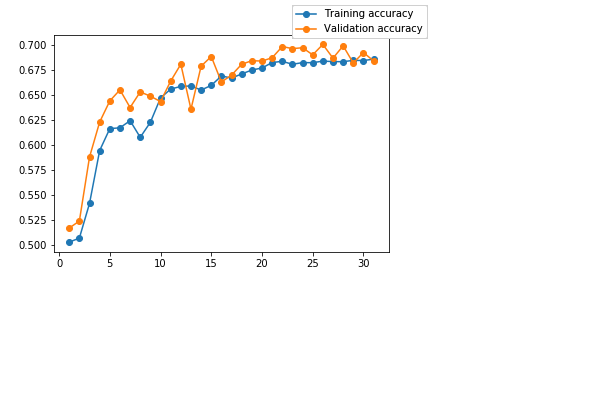

<IPython.core.display.Javascript object>


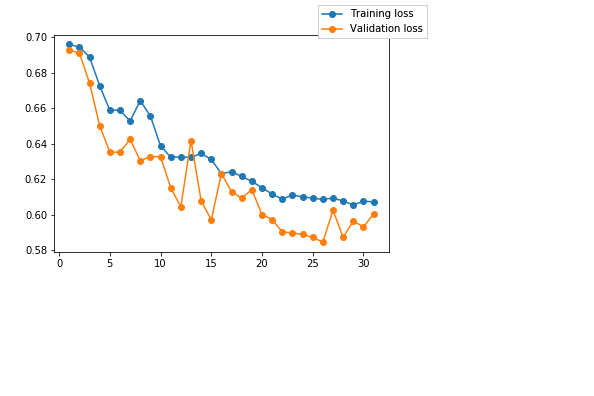

Epoch: 01 | Epoch Time: 5m 14s
	Train Loss: 0.696 | Train Acc: 50.25%
	 Val. Loss: 0.692 |  Val. Acc: 51.66%
Epoch: 02 | Epoch Time: 5m 14s
	Train Loss: 0.694 | Train Acc: 50.65%
	 Val. Loss: 0.691 |  Val. Acc: 52.36%
Epoch: 03 | Epoch Time: 5m 18s
	Train Loss: 0.689 | Train Acc: 54.12%
	 Val. Loss: 0.674 |  Val. Acc: 58.78%
Epoch: 04 | Epoch Time: 5m 12s
	Train Loss: 0.673 | Train Acc: 59.43%
	 Val. Loss: 0.650 |  Val. Acc: 62.29%
Epoch: 05 | Epoch Time: 5m 11s
	Train Loss: 0.659 | Train Acc: 61.63%
	 Val. Loss: 0.635 |  Val. Acc: 64.41%
Epoch: 06 | Epoch Time: 5m 11s
	Train Loss: 0.659 | Train Acc: 61.71%
	 Val. Loss: 0.635 |  Val. Acc: 65.52%
Epoch: 07 | Epoch Time: 5m 19s
	Train Loss: 0.653 | Train Acc: 62.43%
	 Val. Loss: 0.642 |  Val. Acc: 63.75%
Epoch: 08 | Epoch Time: 5m 16s
	Train Loss: 0.664 | Train Acc: 60.76%
	 Val. Loss: 0.630 |  Val. Acc: 65.31%
Epoch: 09 | Epoch Time: 5m 19s
	Train Loss: 0.656 | Train Acc: 62.27%
	 Val. Loss: 0.633 |  Val. Acc: 64.88%
Epoch: 10 | Epoch T

KeyboardInterrupt: 

In [12]:
#0- Set up the plotting figure
%matplotlib inline
%config InlineBackend.figure_format ='svg'
%load_ext autoreload
%autoreload 2
%matplotlib notebook

#1- Set up the optimizer
optimizer = optim.Adam(model.parameters(),weight_decay = 0.0001)
#optimizer = optim.SGD(model.parameters(),lr=1e-3)

#2- Sigmoid and boundary cross entropy
criterion = nn.BCEWithLogitsLoss()

#3- Move them to GPU
model = model.to(device)
criterion = criterion.to(device)

#4- Accuracy function
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

#5- Train function
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#6- Evaluate function
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#7- Epoch running time function

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#8- Train the model
N_EPOCHS = 200

cont = -1
train_loss_vec = np.zeros(N_EPOCHS)
valid_loss_vec = np.zeros(N_EPOCHS)
train_acc_vec = np.zeros(N_EPOCHS)
valid_acc_vec = np.zeros(N_EPOCHS)

best_valid_loss = float('inf')

fig1 = plt1.figure()
ax1 = fig1.add_subplot(111)
fig1.show()
fig1.canvas.draw()

fig2 = plt2.figure()
ax2 = fig2.add_subplot(111)
fig2.show()
fig2.canvas.draw()

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    cont = cont + 1
    train_loss_vec[cont]=train_loss
    valid_loss_vec[cont]=valid_loss
    train_acc_vec[cont]=train_acc
    valid_acc_vec[cont]=valid_acc
    
    ax1.clear()
    ax1.plot(range(1,epoch+2),train_acc_vec[0:cont+1],'-o', label=r'Training accuracy') 
    ax1.plot(range(1,epoch+2),valid_acc_vec[0:cont+1],'-o', label=r'Validation accuracy')
    fig1.legend(loc='best')
    fig1.canvas.draw()
    
    ax2.clear()
    ax2.plot(range(1,epoch+2),train_loss_vec[0:cont+1],'-o', label=r'Training loss') 
    ax2.plot(range(1,epoch+2),valid_loss_vec[0:cont+1],'-o', label=r'Validation loss')
    fig2.legend(loc='best')
    fig2.canvas.draw()

# 6- Final results

In [13]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.584 | Test Acc: 69.86%


# 7- User input

In [7]:
import spacy
nlp = spacy.load('en')

#1- Load model
model.load_state_dict(torch.load('tut2-model.pt'))

#2- Sentiment prediction function
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

#3- Test some sentences
sentence1="The food was very good. I will buy again for sure. Completely recommend it"
out1 = predict_sentiment(model, sentence1) #should be close to 0
print(f'Sentence: {sentence1} | Estimation: {out1}')

sentence2="Don't buy this. It was disgusting and the flavour was weird. I don't recommend it at all"
out2=predict_sentiment(model,sentence2) #should be close to 1
print(f'Sentence: {sentence2} | Estimation: {out2}')

Sentence: The food was very good. I will buy again for sure. Completely recommend it | Estimation: 0.31564512848854065
Sentence: Don't buy this. It was disgusting and the flavour was weird. I don't recommend it at all | Estimation: 0.31054291129112244


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

0.4.1
True
True
